In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
im = plt.imread("img/coins1.jpg")

im.shape

(1600, 1200, 3)

In [3]:
def plot(img,**kwargs):
    plt.figure()
    plt.imshow(img,interpolation="none",**kwargs)
    plt.axis('off')

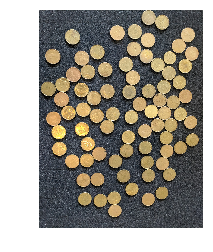

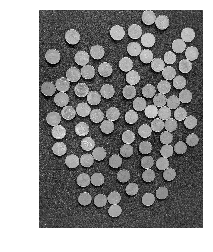

In [4]:
plot(im)
plot(np.mean(im,axis=2),**{'cmap':'gray'})

How can we reduce noise?

# Moving average

REF: NYU computer vision

<img src="img/boxfilter.png"/>

## Convolution

f: image
g: kernel

$f * g = \sum_{k,l}f[m-k,n-l]g[k,l]$

In other words, for every pixel (m,n) inside the box filer centered at the pixel (k,l), sum the difference of a pixel (m,n) and the reference pixel (k,l).

Linearity:        $filter(f_1+f_2) = filter(f_1)+filter(f_2)$

Shift invariance" $filter(shift(f))=shift(filter(f))$

$\frac{(H - h + 2p)}{k}+1=o$

$0 = H$

$2p= H - \frac{(H - h)}{k} -1$

$p = 0.5*(H - \frac{(H - h)}{k} -1)$

In [5]:
def conv2d(f,g,k=1,**kwargs):
    w,h = g.shape
    W,H,D = f.shape
    
    g = np.rot90(g,2)
    
    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))
     
    g = np.repeat(g[:,:,np.newaxis],3,2)
    
    f_pad = np.pad(f,((y_pad,y_pad),(x_pad,x_pad),(0,0)),mode='constant')
    
    new_im = []
    for m in range(int(f_pad.shape[0]-w)+1):
        for n in range(int(f_pad.shape[1]-h+1)):
            fg = np.multiply(f_pad[m:m+w,n:n+h,:],g)
            sum_fg = np.sum(fg,axis=(0,1))
            new_im.append(sum_fg)
            
    return np.array(new_im).reshape(W,H,D)
    

## Original BW - full and slice

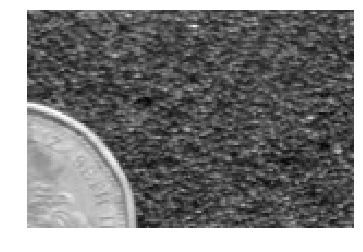

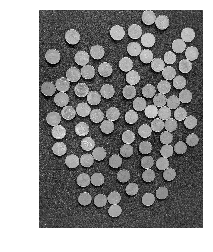

In [6]:
f = im
g1 = np.zeros((3,3))
g1[1,1]=1
plot(np.mean(conv2d(f,g1,k=1)[100:200,250:400],axis=2),**{'cmap':'gray'})
plot(np.mean(conv2d(f,g1,k=1),axis=2),**{'cmap':'gray'})

## Avergage filter (17x17):

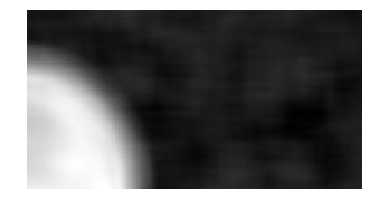

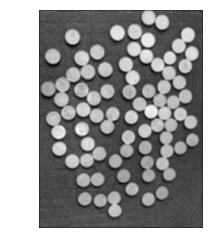

In [7]:
f = im
g2 = np.ones((17,17))*1/(17*17)
plot(np.mean(conv2d(f,g2,k=1)[120:200,250:400],axis=2),**{'cmap':'gray'})
plot(np.mean(conv2d(f,g2,k=1),axis=2),**{'cmap':'gray'})

## Sharpening (17x17)

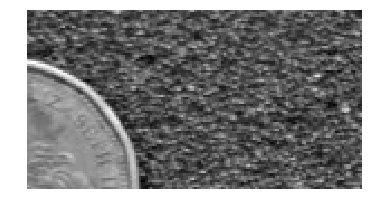

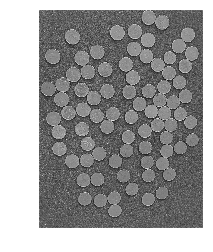

In [8]:
f = im
g1 = np.zeros((17,17))
g1[8,8]=1
g2 = np.ones((17,17))*1/(17*17)
plot(np.mean(conv2d(f,2*g1-g2,k=1),axis=2)[120:200,250:400],**{'cmap':'gray'})
plot(np.mean(conv2d(f,2*g1-g2,k=1),axis=2),**{'cmap':'gray'})

## Gaussian filter

Remove high-frequency components (low-pass filter)

$G_{\sigma}=\frac{1}{2\pi^2}e^{\frac{-(x^2+y^2)}{2\sigma^2}}$

In [9]:
import math
def GaussianFilter(w,h,sigma):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            G.append((1/(2*math.pi*sigma**2))*math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2)))
    
    return np.array(G).reshape(w,h)

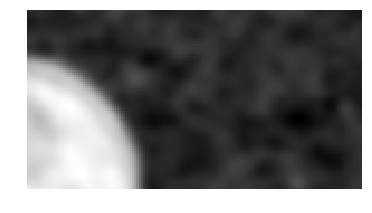

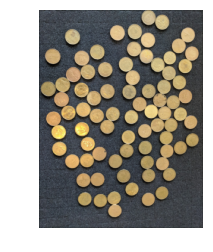

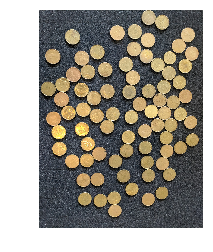

In [10]:
f = im
g3 = GaussianFilter(17,17,3)
plot(np.mean(conv2d(f,g3,k=1)[120:200,250:400],axis=2),**{'cmap':'gray'})
new_im = conv2d(f,g3,k=1)
plot(new_im/255)
plot(im)

# Blob detection (inneficient implementation)

In [11]:
im1 = plt.imread("img/farol1.jpg")

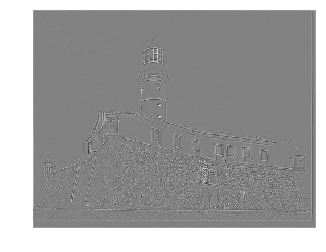

In [12]:

g3 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
plot(np.mean(conv2d(im1,g3,k=1),axis=2),**{'cmap':'gray'})


In [13]:
def laplacian(t,w,sigma):
    return (1/(math.pi*sigma**4))*(1-(t**2+w**2)/(2*sigma**2))*math.e**(-1*(t**2+w**2)/(2*sigma**2))
    
def Lap(w,h,sigma,grad_type='x'):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            if grad_type=='y':
                G.append(laplacian((i-n),(j-n),sigma))
            elif grad_type=='x':
                G.append(laplacian((j-n),(i-n),sigma))
    
    return np.array(G).reshape(w,h)/np.sum(np.array(G))

In [14]:
f = im1
scales = np.arange(0.5,20,0.5)
G = []
for i in scales:
    G1 = np.mean(conv2d(f,(i**2)*Lap(31,31,i),k=1),axis=2)
    G.append(G1)



In [15]:
pyramid = np.stack(G)
pyramid.shape

(39, 382, 497)

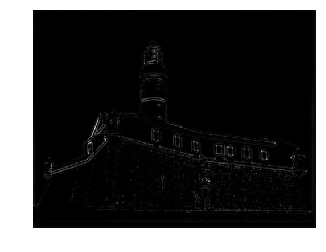

In [16]:
new_im = np.max(pyramid**2,axis=0)
plot(new_im,**{'cmap':'gray'})

In [17]:
pyramid = (pyramid**2)/(pyramid**2).max()
pyramid_max = np.argmax(pyramid,axis=0)

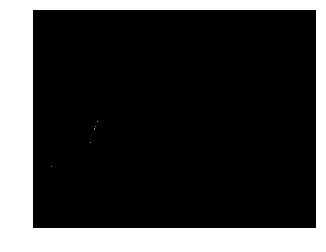

In [18]:
pyramid[pyramid<0.7]=0
new_im = np.max(pyramid**2,axis=0)
plot(new_im,**{'cmap':'gray'})

In [19]:
nonzeros = []

for i in scales:
    pts = np.where(pyramid_max ==i)
    print(pts[0].shape)
    if pts[0].shape[0] !=0:
        nonzeros.append(i)


(0,)
(0,)
(0,)
(189852,)
(0,)
(2,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


In [20]:
from matplotlib.patches import Circle
import pylab as pl
from IPython import display
import time

In [21]:
#scales = np.arange(1,6,.05)
#scales = scales[4:]
for j in np.flip(range(len(nonzeros[:-8])),axis=0):
    pts = np.where(pyramid_max ==np.flip(nonzeros,axis=0)[j])
    for i in range(10):
        if (pts[0].shape[0] == 0)==True:
            break
        k = np.random.randint(0,pts[0].shape[0])
        a,b=pts[0][k],pts[1][k]
        R = scales[j]*np.sqrt(2)
        plt.imshow(im1)       
        circle = Circle((b,a),radius=R,color='red',fill=False,**{"linewidth":2})
        ax = plt.gca()
        ax.add_patch(circle)
        plt.axis('scaled')    

        pl.plot()
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.5)


## Median filtering

In [22]:
def conv2d_median(f,size=(3,3),k=1,**kwargs):
    w,h = size
    W,H,D = f.shape
        
    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))
        
    f_pad = np.pad(f,((y_pad,y_pad),(x_pad,x_pad),(0,0)),mode='constant')
    
    new_im = []
    for m in range(int(f_pad.shape[0]-w)+1):
        for n in range(int(f_pad.shape[1]-h+1)):
            new_im.append(np.median(f_pad[m:m+w,n:n+h,:],axis=(0,1)))
            
            
    return np.array(new_im).reshape(W,H,D)

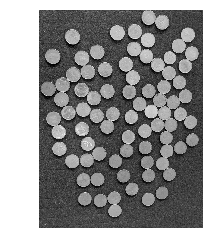

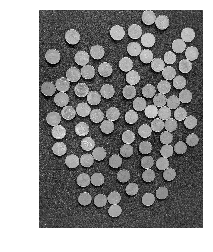

In [23]:
plot(np.mean(conv2d_median(im,size=(3,3),k=1),axis=2),**{'cmap':'gray'})
plot(np.mean(im,axis=2),**{'cmap':'gray'})

# Edges

Identify sudden changes (discontinuities) in an image.

REF: NYU Computer Vision 

<img src='img/lines.png'>

## Image gradient

Taylor series, finite differences. Gradient direction is given by the arctan of grad_y/grad_x. Edge strength os given by the magnitude of the gradient (modulus)

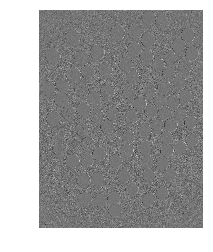

In [24]:
kernel_x= np.array([[0,0,0],[0,-1,1],[0,0,0]])
plot(np.mean(conv2d(im,kernel_x,k=1),axis=2),**{'cmap':'gray'})

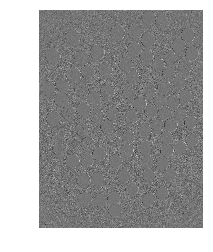

In [25]:
kernel_y= np.array([[0,0,0],[0,-1,0],[0,1,0]])
plot(np.mean(conv2d(im,kernel_x,k=1),axis=2),**{'cmap':'gray'})

### Prewitt

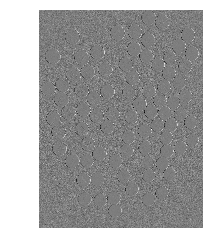

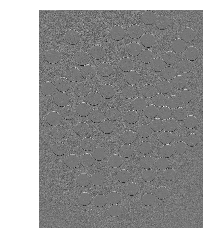

In [26]:
Mx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
My = np.rot90(Mx)

plot(np.mean(conv2d(im,Mx,k=1),axis=2),**{'cmap':'gray'})
plot(np.mean(conv2d(im,My,k=1),axis=2),**{'cmap':'gray'})

### Sobel

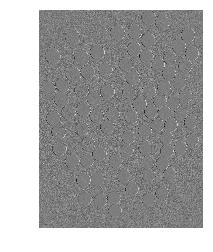

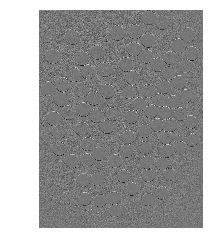

In [27]:
Mx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
My = np.rot90(Mx)

plot(np.mean(conv2d(im,Mx,k=1),axis=2),**{'cmap':'gray'})
plot(np.mean(conv2d(im,My,k=1),axis=2),**{'cmap':'gray'})

### Roberts

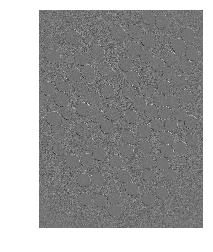

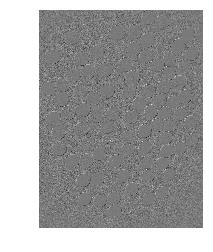

In [28]:
Mx = np.array([[0,0,1],[0,-1,0],[0,0,0]])
My = np.rot90(Mx)

plot(np.mean(conv2d(im,Mx,k=1),axis=2),**{'cmap':'gray'})
plot(np.mean(conv2d(im,My,k=1),axis=2),**{'cmap':'gray'})

Finite differences filters are sensitive to noise, pixels that look very different from neighbors.
Smoothing aleviates this problem.

In [29]:
import math
def GaussianFilter(w,h,sigma):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            G.append((1/(2*math.pi*sigma**2))*math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2)))
    
    return np.array(G).reshape(w,h)

Mx= np.array([[0,0,0],[0,-1,1],[0,0,0]])
My= np.array([[0,0,0],[0,-1,0],[0,1,0]])

In [30]:
g = GaussianFilter(17,17,1)

$-\frac{x}{2 \pi \sigma^4}e^{-\frac{(x^2+y^2)}{2 \sigma^2}$

grad_X = $G_{\sigma}=\frac{x}{2\pi\sigma^4}e^{\frac{-(x^2+y^2)}{2\sigma^2}}$

grad_X = $G_{\sigma}=\frac{y}{2\pi\sigma^4}e^{\frac{-(x^2+y^2)}{2\sigma^2}}$

In [31]:
def gradientG(t,w,sigma):
    return (-t/(2*math.pi*sigma**4))*math.e**(-1*(t**2+w**2)/(2*sigma**2))
    
def DOG(w,h,sigma,grad_type='x'):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            if grad_type=='y':
                G.append(gradientG((i-n),(j-n),sigma))
            elif grad_type=='x':
                G.append(gradientG((j-n),(i-n),sigma))
    
    return np.array(G).reshape(w,h)

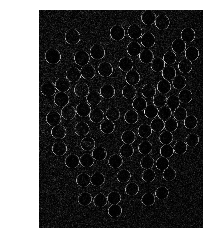

In [32]:
g = DOG(7,7,7/3,'x')
plot(np.mean(np.abs(conv2d(im,g,k=1)),axis=2),**{'cmap':'gray'})

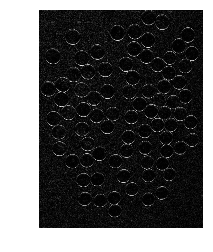

In [33]:
g = DOG(7,7,7/3,'y')
plot(np.mean(np.abs(conv2d(im,g,k=1)),axis=2),**{'cmap':'gray'})

# Canny edge detector

In [34]:
import numpy.ma as ma

def peakDetection(x0,n_pad,S_pad):

    n0 = np.array(([n_pad[0][x0],n_pad[1][x0]]))

    q0 = x0 + n0*1/(2*math.sin(math.pi/8))

    k,l=np.rint(q0).astype(int).tolist()
    
    return S_pad[x0[0],x0[1]]>S_pad[k,l]


def canny(im,th=0.1,fsize=(3,3),sigma=1):
    M = im
    h,w = fsize
    gx =  DOG(h,w,sigma,'x')
    gy =  DOG(h,w,sigma,'y')

    grad_x = np.mean(conv2d(M,gx),axis=2)
    grad_y = np.mean(conv2d(M,gy),axis=2)

    R = (grad_x,grad_y)

    S = np.sqrt(grad_x**2+grad_y**2)
    mask = ma.masked_where(S > th*S.max(), S).mask

    n = mask*np.divide(R,S,out=np.zeros_like(R),where=S!=0)

    plot(S,**{'cmap':'gray'})
    
    H,W = S.shape
    k=1
    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+h))

    S_pad = np.pad(S,((y_pad,y_pad),(x_pad,x_pad)),mode='constant')
    nx_pad = np.pad(n[0],((y_pad,y_pad),(x_pad,x_pad)),mode='constant')
    ny_pad = np.pad(n[1],((y_pad,y_pad),(x_pad,x_pad)),mode='constant')

    peaks = np.zeros_like(S)
    count=0
    for i in range(H):
        for j in range(W):
            x0 = (i+1,j+1)

            if peakDetection(x0,(nx_pad,ny_pad),S_pad)==True:
                peaks[i,j]=1

            count+=1  
    print("Sanity check: {}".format(count==H*W))
    plot(peaks,**{'cmap':'gray'})
    return peaks

Sanity check: True


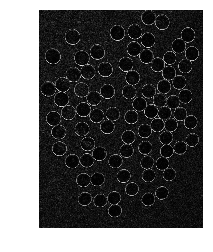

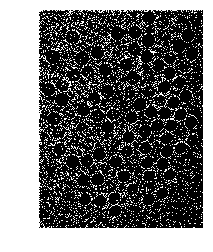

In [35]:
pk = canny(im,th=0.1,fsize=(7,7),sigma=7/3)

## Gaussian and Laplacian filters

## Tests with line/stripes

In [36]:
line = plt.imread("img/blackline.png")
stripes = plt.imread("img/stripes.jpg")

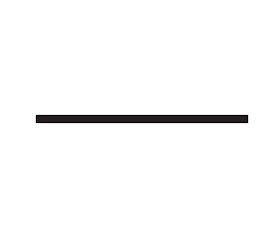

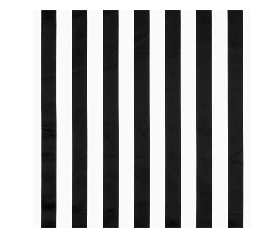

In [37]:
plot(line)
plot(stripes)

### Lines

In [38]:
#https://gist.github.com/CMCDragonkai/dd420c0800cba33142505eff5a7d2589
from mpl_toolkits.mplot3d import Axes3D

def surface_plot (matrix, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    

    return (fig, ax, surf)
    

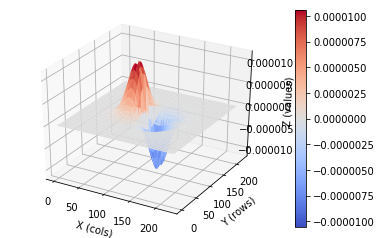

In [39]:
H,W,_ = line.shape
m = GaussianFilter(H,W,1)
n = DOG(W,H,20,grad_type='x')

(fig, ax, surf) = surface_plot(n*np.mean(line,axis=2), cmap=plt.cm.coolwarm)

fig.colorbar(surf)

ax.set_xlabel('X (cols)')
ax.set_ylabel('Y (rows)')
ax.set_zlabel('Z (values)')

plt.show()

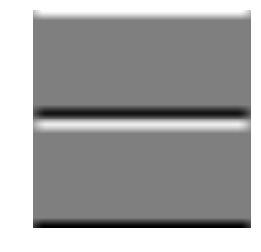

In [40]:
g = DOG(21,21,21/3,grad_type='y')
plot(np.mean(conv2d(line,g,k=1),axis=2),**{'cmap':'gray'})

In [41]:
n = np.mean(conv2d(line,g,k=1),axis=2)

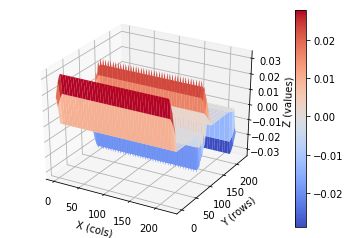

In [42]:
(fig, ax, surf) = surface_plot(n, cmap=plt.cm.coolwarm)

fig.colorbar(surf)

ax.set_xlabel('X (cols)')
ax.set_ylabel('Y (rows)')
ax.set_zlabel('Z (values)')

plt.show()

### Stripes

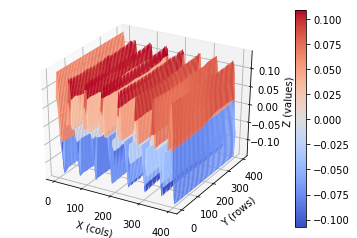

In [43]:
H,W,_ = stripes.shape
m = DOG(17,17,20,grad_type='x')
n = np.mean(conv2d(stripes,m,k=1),axis=2)

(fig, ax, surf) = surface_plot(n, cmap=plt.cm.coolwarm)

fig.colorbar(surf)

ax.set_xlabel('X (cols)')
ax.set_ylabel('Y (rows)')
ax.set_zlabel('Z (values)')

plt.show()

In [44]:
im = plt.imread('img/triangle.jpg')
im = np.mean(im,axis=2)
pk = canny(im,th=0.1,fsize=(7,7),sigma=7/3)

ValueError: not enough values to unpack (expected 3, got 2)